# <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:200%; text-align:center;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0">S3E26 - BOOSTING (VOTING)</div>
Notebook edited from [dreygaen/ps3e25-cirrhosis-multi-class-solution](https://www.kaggle.com/code/dreygaen/ps3e25-cirrhosis-multi-class-solution)
#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:150%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" >TABLE OF CONTENTS<br><div>
* [IMPORTS](#1)
* [LOAD DATA](#2)
* [EDA AND VISUALS](#3)
* [FEATURE ENGINEERING](#4)
* [MODEL](#5)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > IMPORTS<br><div> 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import zipfile

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (median_absolute_error, roc_auc_score, roc_curve, log_loss, ConfusionMatrixDisplay, 
                             confusion_matrix)
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, PowerTransformer, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, early_stopping
from catboost import CatBoostRegressor, CatBoostClassifier
from sklego.linear_model import LADRegression
import optuna
from itertools import combinations, permutations

optuna.logging.set_verbosity(optuna.logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
tqdm.pandas()

rc = {
    'axes.facecolor': '#FFEDED',
    'figure.facecolor': '#FFEDED',
    'axes.edgecolor': '#000000',
    'grid.color': '#EBEBE7',
    'font.family': 'serif',
    'axes.labelcolor': '#000000',
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'grid.alpha': 0.4
}

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL
bold_start = Style.BRIGHT
bold_end = Style.NORMAL

target_col = 'Status'

<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > LOAD DATA<br><div> 

In [4]:
with zipfile.ZipFile('../../../res/data/playground-series-s3e26.zip', 'r') as z:
    
    with z.open('train.csv') as f:
        train = pd.read_csv(f, index_col = 'id')        
                
    with z.open('test.csv') as f:
        test = pd.read_csv(f, index_col = 'id')
    
    with z.open('sample_submission.csv') as f:
        submission = pd.read_csv(f)
        
with zipfile.ZipFile('../../../res/data/cirrhosis-patient-survival-prediction.zip', 'r') as z:
    with z.open('cirrhosis.csv') as f:
        orig_data = pd.read_csv(f, index_col = 'ID') 

In [5]:
train = pd.concat([train, orig_data], axis=0, ignore_index=True)
cat_cols = train.select_dtypes(include = ['O']).columns

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > FEATURE ENGINEERING<br><div> 

In [6]:

# original notebook applied fit_transform on training data.
train_cat_cols = train.select_dtypes(include=['object']).columns
for col in train_cat_cols:
    label_encoder = LabelEncoder()
    train[col] = label_encoder.fit_transform(train[col])
    if col != target_col:
        test[col] = label_encoder.transform(test[col])

In [7]:
# train_drop = train.dropna()
# X = train_drop.drop([target_col], axis=1)
# y = train_drop[target_col]

X = train.drop([target_col], axis=1)
y = train[target_col]

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > MODELS<br><div> 

In [26]:

xgb_params = {
    'objective': 'multi_logloss', 
    'max_depth': 3, 
    'learning_rate': 0.010009541152584345, 
    'n_estimators': 2600,
    'min_child_weight': 9, 
    # 'colsample_bytree': 0.3292032860985591, 
    # 'reg_alpha': 0.10626128775335533, 
    # 'reg_lambda': 0.624196407787772, 
    'tree_method': 'hist', 
    'eval_metric': 'mlogloss',
    # 'subsample': 0.47524425009347593
}

cat_params = {
    'iterations':1000,
    # 'depth': 20,
    'learning_rate': 0.138112945166,
    'l2_leaf_reg': 4.0368544113430485,
    'random_strength': 0.1279482215776108,
    'max_bin': 238,
    'od_wait': 49,
    'one_hot_max_size': 39,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bernoulli',
    'od_type': 'IncToDec', #'Iter',    
    'min_data_in_leaf': 6,
    'loss_function': 'MultiClass',
    'verbose': False,
}

lgbm_params = {
    'objective': 'multiclass', #'multi_logloss', 
    'num_class': 3,
    'metric': 'multi_logloss',
    'max_depth': 21, 
    'min_child_samples': 14, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 250, 
    'min_child_weight': 9, 
    'colsample_bytree': 0.1702910221565107, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'verbose': -1,

}

hgb_params = {
    # 'learning_rate': 1,
    'max_iter': 100,
    'max_leaf_nodes': 31,
    'max_depth': None,
    'min_samples_leaf': 20,
    'l2_regularization': 0,
    'max_bins': 255,
    'categorical_features': [col for col in cat_cols if col != 'Status'],
    'monotonic_cst': None,
    'interaction_cst': None,
    'scoring': 'log_loss',
    'validation_fraction': 0.1,
    'class_weight': None,
}
N_FOLDS = 5
N_REPEATS = 3
random_state = 524198542
k_fold = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=random_state)

def objective(trial):
    # random_state = trial.suggest_int('random_state', 1, 10000, log=False)

    
    # lgbm_max_depth=trial.suggest_int("lgbm_max_depth_uni", 15, 25, log=False)
    lgbm_max_depth = lgbm_params['max_depth']
    # List of classifiers
    estimators = [
        ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(
            learning_rate=trial.suggest_float("hgb_learning_rate", 0.01, 0.25, log=False),
            random_state=random_state,
            **hgb_params
            )),
        ("XGBClassifier", XGBClassifier(
            # max_depth=trial.suggest_int("xgb_max_depth_uni", 3, 7, log=False),
            # min_child_weight=trial.suggest_int("xgb_min_child_weight_uni", 1, 20, log=False),
            # learning_rate=trial.suggest_float("xgb_learning_rate_uni", 0.005, 0.015, log=False),
            # n_estimators=trial.suggest_int("xgb_n_estimators_uni", 2500, 4000, step=100),
            reg_alpha=trial.suggest_float("xgb_reg_alpha", 0.025, 0.075, log=False),
            reg_lambda=trial.suggest_float("xgb_reg_lambda", 0.65, 0.8, log=False),    
            subsample=trial.suggest_float("xgb_subsample_uni", 0.4, 0.45, log=False),
            colsample_bytree=trial.suggest_float("xgb_colsample_bytree", 0.4, 0.5, log=False),
            random_state=random_state,
            **xgb_params
            )),
        # ("CatBoostClassifier", CatBoostClassifier(
        #     # depth=trial.suggest_int("cat_depth_uni", 15, 25, step=5),
        #     max_depth=trial.suggest_int("cat_max_depth_uni", 8, 12,  log=False),
        #     # max_bin=trial.suggest_int("cat_max_bin_uni", 50, 500, log=False),
        #     # learning_rate=trial.suggest_float("cat_learning_rate_uni", 0.1, 0.5, log=False),
        #     # iterations=trial.suggest_int("cat_iterations_uni", 300, 600, log=False),
        #     # min_data_in_leaf=trial.suggest_int("cat_min_data_in_leaf_uni", 5, 15, log=False),
        #     random_seed=random_state,
        #     **cat_params
        #     )),
        ("LGBMClassifier", LGBMClassifier(
            # max_depth=lgbm_max_depth,
            num_leaves=2**lgbm_max_depth - 1 if 2**lgbm_max_depth - 1 <= 131072 else 131072,
            # min_child_samples=trial.suggest_int("lgbm_min_child_samples_uni", 10, 30, log=False),
            # min_gain_to_split=trial.suggest_float("lgbm_min_gain_to_split", 0.0, 0.1, step=0.01),
            # learning_rate=trial.suggest_float("lgbm_learning_rate_uni", 0.02, 0.04, log=False),
            # n_estimators=trial.suggest_int("lgbm_n_estimators_uni", 250, 300, step=5),
            # colsample_bytree=trial.suggest_float("lgbm_colsample_bytree", 2/18, 4/18, log=False),
            random_state=random_state,
            **lgbm_params
            )),

    ]
    # voting = trial.suggest_categorical("voting", ['soft', 'hard'])
    hgb_weight = trial.suggest_float("hgb_weight_log", 0.5, 2.5, log=True)
    xgb_weight = trial.suggest_float("xgb_weight_log", 1, 5, log=True)
    # cat_weight = trial.suggest_float("cat_weight_log", 1, 5, log=True)
    lgbm_weight = trial.suggest_float("lgbm_weight_log", 7.5, 10, log=True)

    classifier = VotingClassifier(estimators=estimators, voting='soft', weights=[hgb_weight, xgb_weight, 
                                                                                 # cat_weight, 
                                                                                 lgbm_weight, ])
    score = cross_val_score(classifier, X, y, n_jobs=-1, cv=k_fold, scoring='neg_log_loss', verbose=False)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="voting-boosting-v4-2",
    direction='maximize',
    load_if_exists=True,
)
study.optimize(objective, n_trials=100)

print(study.best_trial)


/Users/seanbearden/PycharmProjects/Kaggle/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/seanbearden/PycharmProjects/Kaggle/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/seanbearden/PycharmProjects/Kaggle/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/seanbearden/PycharmProjects/Kaggle/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/seanbearden/PycharmProjects/Kaggle/venv/lib/python3.10/site-packages/

KeyboardInterrupt: 

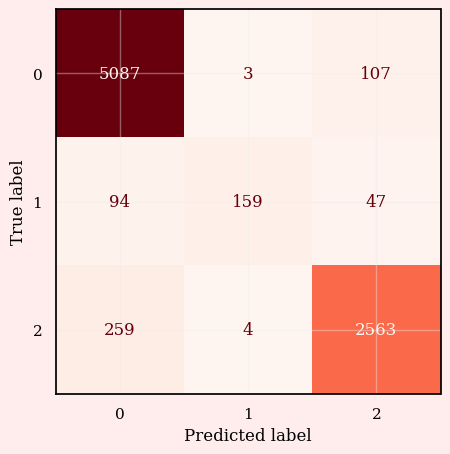

In [28]:
random_state = random_state

best_params = study.best_params

# lgbm_max_depth = best_params['lgbm_max_depth_uni']
lgbm_max_depth = lgbm_params['max_depth']


# List of classifiers
estimators = [
    ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(
            learning_rate=best_params["hgb_learning_rate"],
            random_state=random_state,
            **hgb_params
            )),
    ("XGBClassifier", XGBClassifier(
            # max_depth=best_params["xgb_max_depth_uni"],
            # min_child_weight=best_params["xgb_min_child_weight_uni"],
            # learning_rate=best_params["xgb_learning_rate_uni"],
            # n_estimators=best_params["xgb_n_estimators_uni"],
            reg_alpha=best_params["xgb_reg_alpha"],
            reg_lambda=best_params["xgb_reg_lambda"], 
            subsample=best_params["xgb_subsample_uni"],
            colsample_bytree=best_params["xgb_colsample_bytree"],
            random_state=random_state,
            **xgb_params
        )),
    # ("CatBoostClassifier", CatBoostClassifier(
    #         # depth=best_params["cat_depth_uni"],
    #         max_depth=best_params["cat_max_depth_uni"],
    #         # max_bin=best_params["cat_max_bin_uni"],
    #         # learning_rate=best_params["cat_learning_rate_uni"],
    #         # iterations=best_params["cat_iterations_uni"],
    #         # min_data_in_leaf=best_params['cat_min_data_in_leaf_uni'],
    #         random_seed=random_state,
    #         **cat_params
    #     )),
    ("LGBMClassifier", LGBMClassifier(
            # max_depth=lgbm_max_depth,
            num_leaves=2**lgbm_max_depth - 1 if 2**lgbm_max_depth - 1 <= 131072 else 131072,
            # min_child_samples=best_params["lgbm_min_child_samples_uni"],
            # min_gain_to_split=best_params["lgbm_min_gain_to_split"],
            # learning_rate=best_params["lgbm_learning_rate_uni"],
            # n_estimators=best_params["lgbm_n_estimators_uni"],
            # colsample_bytree=best_params["lgbm_colsample_bytree"],
            random_state=random_state,
            **lgbm_params
        )),
]

hgb_weight = best_params["hgb_weight_log"]
xgb_weight = best_params["xgb_weight_log"]
# cat_weight = best_params["cat_weight_log"]
lgbm_weight = best_params["lgbm_weight_log"]

classifier = VotingClassifier(estimators=estimators, voting='soft', weights=[hgb_weight, xgb_weight, #cat_weight, 
                                                                             lgbm_weight])

classifier.fit(X, y)

y_pred_cm = classifier.predict(X)

fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(y, y_pred_cm, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Reds, ax= ax, 
colorbar=False, text_kw={"fontsize":12})
plt.show()

In [29]:
y_pred = classifier.predict_proba(X)
print(f'log loss: {log_loss(y, y_pred)}')

log loss: 0.21112016075776274


<table style="border: 2px solid purple;">
  <tr>
    <th style="border: 2px solid purple;">Version</th>
    <th style="border: 2px solid purple;">Log Loss</th>
    <th style="border: 2px solid purple;">Public Score</th>
    <th style="border: 2px solid purple;">Note</th>
  </tr>
  <tr>
    <td style="border: 2px solid purple;">v2-1</td>
    <td style="border: 2px solid purple;">0.21869062514383641</td>
    <td style="border: 2px solid purple;">0.39293</td>
    <td style="border: 2px solid purple;">better with lgbm_max_depth >= 10</td>
  </tr>
  <tr>
    <td style="border: 2px solid purple;">v3-0</td>
    <td style="border: 2px solid purple;">0.21241161619805454</td>
    <td style="border: 2px solid purple;">0.39554</td>
    <td style="border: 2px solid purple;">Not many trials</td>
  </tr>
  <tr>
    <td style="border: 2px solid purple;">v3-1</td>
    <td style="border: 2px solid purple;">0.2229539616567262</td>
    <td style="border: 2px solid purple;">0.396</td>
    <td style="border: 2px solid purple;">LGBM colsample by tree and n estimators most infulential.</td>
  </tr>
  <tr>
    <td style="border: 2px solid purple;">v4-00</td>
    <td style="border: 2px solid purple;">0.19821939346581285</td>
    <td style="border: 2px solid purple;">0.3944</td>
    <td style="border: 2px solid purple;">Added HGB</td>
  </tr>
  <tr>
    <td style="border: 2px solid purple;">v4-1</td>
    <td style="border: 2px solid purple;">0.21046925990536525</td>
    <td style="border: 2px solid purple;">0.39475</td>
    <td style="border: 2px solid purple;">Removed CATBoost</td>
  </tr>
</table>



<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > SUBMISSION<br><div> 

In [22]:
pred = classifier.predict_proba(test)

submission['Status_C'] =  pred[:, 0]
submission['Status_CL'] = pred[:, 1]
submission['Status_D'] =  pred[:, 2]

submission.to_csv('submission.csv', index = False)

In [23]:
%%bash
kaggle competitions submit playground-series-s3e26 -f submission.csv -m "Voting v4-1"
kaggle competitions submissions playground-series-s3e26



100%|██████████| 336k/336k [00:01<00:00, 206kB/s] 


Successfully submitted to Multi-Class Prediction of Cirrhosis OutcomesfileName        date                 description                                            status    publicScore  privateScore  
--------------  -------------------  -----------------------------------------------------  --------  -----------  ------------  
submission.csv  2023-12-20 16:15:37  Voting v4-1                                            complete  0.39475                    
submission.csv  2023-12-20 13:35:34  Voting v4                                              complete  0.3944                     
submission.csv  2023-12-20 01:41:35  Voting v3-1                                            complete  0.396                      
submission.csv  2023-12-19 10:58:53  Voting v3-0                                            complete  0.39554                    
submission.csv  2023-12-19 09:53:50  Voting v2                                              complete  0.39293                    
submission.csv  2023

In [54]:
cat_cols = train.select_dtypes(include = ['O']).columns

In [55]:
cat_cols

Index([], dtype='object')

<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" >MODIFY PROBABILITY<br><div> 

In [38]:
storage_name="sqlite:///db.sqlite3"
study_name="voting-boosting-v2-1" # Specify the storage name, e.g., an SQLite database
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_params = study.best_params

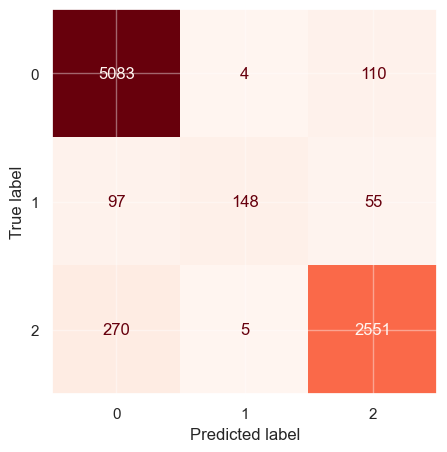

In [39]:
random_state = 1001

xgb_params = {
    'objective': 'multi_logloss', 
    'max_depth': best_params['xgb_max_depth_uni'],#3, 
    'learning_rate': 0.010009541152584345, 
    'n_estimators': 1878,
    'min_child_weight': 9, 
    'colsample_bytree': 0.3292032860985591, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'tree_method': 'hist', 
    'eval_metric': 'mlogloss',
    'subsample': 0.47524425009347593,
    'random_state': random_state

}

cat_params = {
    'iterations':1000,
    # 'depth': 20,
    'max_depth': best_params['cat_max_depth_uni'],
    'learning_rate': 0.138112945166,
    'l2_leaf_reg': 4.0368544113430485,
    'random_strength': 0.1279482215776108,
    'max_bin': 238,
    'od_wait': 49,
    'one_hot_max_size': 39,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bernoulli',
    'od_type': 'IncToDec', #'Iter',    
    'min_data_in_leaf': best_params['cat_min_data_in_leaf_uni'], #6,
    'loss_function': 'MultiClass',
    'verbose': False,
    'random_seed': random_state

}

lgbm_params = {
    'objective': 'multiclass', #'multi_logloss', 
    'num_class': 3,
    'metric': 'multi_logloss',
    'max_depth': best_params['lgbm_max_depth_uni'], #21, 
    'num_leaves': 2**best_params['lgbm_max_depth_uni'] - 1 if 2**best_params['lgbm_max_depth_uni'] - 1 <= 131072 else 131072,
    'min_child_samples': 14, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': best_params['lgbm_n_estimators_uni'], #250 
    'min_child_weight': 9, 
    'colsample_bytree': 0.1702910221565107, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'verbose': -1,
    'random_state': random_state
}

# List of classifiers
estimators = [
    ("XGBClassifier", XGBClassifier(**xgb_params)),
    ("CatBoostClassifier", CatBoostClassifier(**cat_params)),
    ("LGBMClassifier", LGBMClassifier(**lgbm_params)),
]

xgb_weight = best_params["xgb_weight_log"]
cat_weight = best_params["cat_weight_log"]
lgbm_weight = best_params["lgbm_weight_log"]

classifier = VotingClassifier(estimators=estimators, voting='soft', weights=[xgb_weight, cat_weight, lgbm_weight])

classifier.fit(X, y)

y_pred_cm = classifier.predict(X)

fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(y, y_pred_cm, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Reds, ax= ax, 
colorbar=False, text_kw={"fontsize":12})
plt.show()

In [40]:
y_pred = classifier.predict_proba(X)
print(f'log loss: {log_loss(y, y_pred)}')
pred = classifier.predict_proba(test)

submission['Status_C'] =  pred[:, 0]
submission['Status_CL'] = pred[:, 1]
submission['Status_D'] =  pred[:, 2]

submission.to_csv('submission-v2-1-baseline.csv', index = False)


log loss: 0.21801073059807927


In [58]:
submission_copy = submission.copy()

# for index, row in submission_copy.drop('id', axis=1).iterrows():
#     max_val_index = row.idxmax()
#     submission_copy.loc[index, submission_copy.columns != 'id'] = 0  # Set all non-id values in the row to 0
#     submission_copy.loc[index, max_val_index] = 1  # Set the max value to 1

for index, row in submission_copy.drop('id', axis=1).iterrows():
    max_val_index = row.idxmin()
    submission_copy.loc[index, max_val_index] = submission_copy.loc[index, max_val_index] / 2
    
    submission_copy.loc[index, submission_copy.columns != 'id'] /= submission_copy.loc[index, submission_copy.columns
                                                                                              != 'id'].sum()
    
    
submission_copy.to_csv('submission-v2-1-reduce-min.csv', index = False)
submission_copy
# for i in range(y_pred.shape[0]):
#     max_val_index = y_pred[i].argmax()
#     y_pred[i] = 0  # Set all values in the row to 0
#     y_pred[i, max_val_index] = 1  # Set the max value to 1
# 
# 
# ll = log_loss(y, y_pred)
# print(f'log loss: {ll}')

,id,Status_C,Status_CL,Status_D
0,7905,0.363450,0.016612,0.619938
1,7906,0.513069,0.148027,0.338904
2,7907,0.022254,0.006636,0.971109
3,7908,0.977644,0.001587,0.020770
4,7909,0.894715,0.032326,0.072959
...,...,...,...,...
5266,13171,0.866852,0.095396,0.037752
5267,13172,0.975597,0.002844,0.021559
5268,13173,0.946985,0.005134,0.047882
5269,13174,0.985471,0.004005,0.010523


<table style="border: 2px solid purple;">
  <tr>
    <th style="border: 2px solid purple;">Version</th>
    <th style="border: 2px solid purple;">Log Loss</th>
    <th style="border: 2px solid purple;">Public Score</th>
    <th style="border: 2px solid purple;">Note</th>
  </tr>
  <tr>
    <td style="border: 2px solid purple;">v2-1 Baseline</td>
    <td style="border: 2px solid purple;">0.21801073059807927</td>
    <td style="border: 2px solid purple;">0.39606</td>
    <td style="border: 2px solid purple;">baseline</td>
  </tr>
</table>



In [59]:
%%bash
kaggle competitions submit playground-series-s3e26 -f submission-v2-1-reduce-min.csv -m "Voting v2-1 reduce min"
kaggle competitions submissions playground-series-s3e26

100%|██████████| 338k/338k [00:01<00:00, 204kB/s] 


Successfully submitted to Multi-Class Prediction of Cirrhosis OutcomesfileName                        date                 description                                            status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------------------------  --------  -----------  ------------  
submission-v2-1-reduce-min.csv  2023-12-22 14:25:30  Voting v2-1 reduce min                                 complete  0.39708                    
submission-v2-1-drop-min.csv    2023-12-22 14:23:38  Voting v2-1 drop min                                   complete  0.96783                    
submission-v2-1-threshold.csv   2023-12-22 14:18:46  Voting v2-1 threshold                                  complete  5.2103                     
submission-v2-1-threshold.csv   2023-12-22 14:18:01  Voting v2-1 baseline                                   complete  0.39606                    
submission-v2-1-baseline.csv    2023-12-22 14:02:53  V